# Full Artificial Neural Network CLASSIFICATION

## Model
* categorical values
* continuous values
* embeddings
* batch normalization
* dropout layers

## Perform standard imports

In [50]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load dataset


In [223]:
features_csv_path = 'full_features.csv'
target_variable = 'grade'
drop_columns = ['id', 'grade', 'benchmark', 'start1', 'start2', 'end']

df = pd.read_csv(features_csv_path)
df_umap = pd.read_csv('umap_features_15_dim')
def clean(x):
    
    x[x.start1]=2
    x[x.start2]=2
    x[x.end]=3
    
    return x

df = df.transform(lambda x:clean(x),axis=1)
df = df.drop(columns = ['id',  'benchmark', 'start1', 'start2', 'end'])




## Optional include UMAP columns

In [224]:

df_umap = pd.read_csv('umap_features_15_dim')
for col in df_umap.columns:
    df[col] = df_umap[col]

(29181, 163) (29181, 16)


## Separate categorical from continuous columns

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [227]:
cat_cols = list(df.columns[1:142])
cont_cols = list(df.columns[143:])
y_col = ['grade']  # this column contains the labels

## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. 

In [228]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [229]:
df.dtypes

grade      object
G2       category
J2       category
B3       category
D3       category
           ...   
10        float64
11        float64
12        float64
13        float64
14        float64
Length: 179, dtype: object

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [308]:
for c in cat_cols:
            df[c] = df[c].astype("category")

cats = np.stack(
    [df[c].cat.codes.values for c in cat_cols], axis=1
)



## Convert numpy arrays to tensors

In [309]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor


We can feed all of our continuous variables into the model as a tensor. We're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [310]:
# Convert continuous variables to a tensor
conts = np.stack([np.array(df[col].values,dtype=np.float16) for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float16)


Note: the CrossEntropyLoss function we'll use below expects a 1d y-tensor, so we'll replace <tt>.reshape(-1,1)</tt> with <tt>.flatten()</tt> this time.

In [311]:
# Convert labels to a tensor
y = torch.tensor(np.array(df[y_col].values,dtype=np.float16),dtype=torch.float16).flatten()
y =y.type(torch.LongTensor)


## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [312]:

cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]


## Define a Model


In [247]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [274]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 14, [1000,100,20,10], p=0.5) # out_sz = 2

In [275]:
model = model.cuda()

## Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [276]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [313]:
# replace this numbers for training or testing with smaller dataset
batch_size = 23344 
test_size = 5836

cat_train = cats[:batch_size-test_size].cuda()
cat_test = cats[batch_size-test_size:batch_size].cuda()
con_train = conts[:batch_size-test_size].cuda()
con_test = conts[batch_size-test_size:batch_size].cuda()
y_train = y[:batch_size-test_size].cuda()
y_test = y[batch_size-test_size:batch_size].cuda()

## Train the model

In [280]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.cpu().detach().numpy())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 2.98568010
epoch:  26  loss: 1.90565228
epoch:  51  loss: 1.62155509
epoch:  76  loss: 1.51942515
epoch: 101  loss: 1.46452081
epoch: 126  loss: 1.41389370
epoch: 151  loss: 1.37484455
epoch: 176  loss: 1.33056426
epoch: 201  loss: 1.30216694
epoch: 226  loss: 1.26996040
epoch: 251  loss: 1.24268556
epoch: 276  loss: 1.20263755
epoch: 300  loss: 1.18342972

Duration: 112 seconds


## Plot the loss function

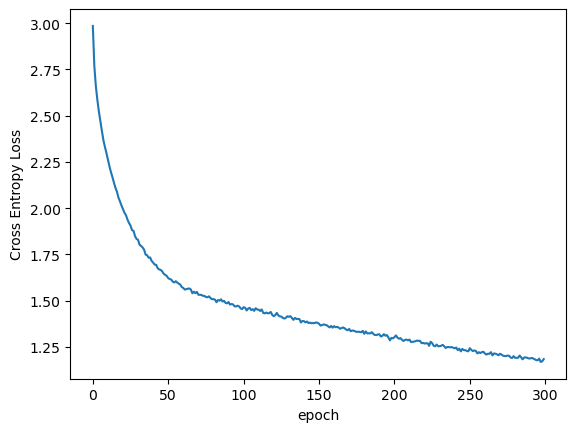

In [282]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Validate the model

In [283]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 1.56392229


Now let's look at the first 50 predicted values

In [301]:
rows = 5836
correct = 0
within_a_grade = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
y_res = []
for i in range(rows):
    #print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
    y_res.append(y_val[i].argmax().item())    
    if abs(y_val[i].argmax().item() - y_test[i])<=1.00001:
        within_a_grade += 1    
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')
print(f'\n{within_a_grade} out of {rows} = {100*within_a_grade/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST

2950 out of 5836 = 50.55% correct

4495 out of 5836 = 77.02% correct


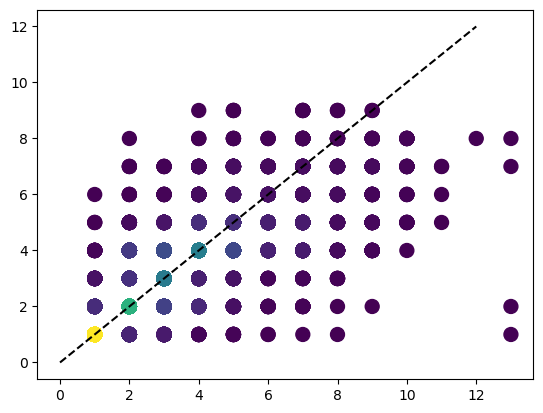

In [307]:
import scipy.stats as sps
with torch.no_grad():
    y_pred = model(cat_test, con_test)

yTest = y_test.cpu().detach().numpy()
y_res = np.array(y_res)


xy = np.vstack([yTest, y_res])
z = sps.gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(yTest, y_res, c=z, s=100)
plt.plot([0, 12], [0, 12], 'k--')
plt.show()



## Save the model
Save the trained model to a file in case you want to come back later and feed new data through it.

In [150]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'model_name.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

Once the model is set up, loading the saved settings is a snap.

In [3]:
model.load_state_dict(torch.load('model_name.pt'))
model.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)